In [1]:
import numpy as np
from scipy import linalg
import os
import re
import linecache
import sys

import multiprocessing as mp

import copy
import pp, time

In [2]:
from VASP_common_utilites import *
from nearest_neighbours_A_B import  *
from parse_outcar import *
from KDE_PSO import *

/home/sf/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/sf/.local/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
def set_vals_in_array(array, vals2search, new_vals):
    """
    Replaces all values in the input "array" 
    defined in "vals2search" by values in the "new_vals"
    """
    corr_array = np.copy(array)
    for i in range(vals2search.shape[0]):
        idxs = np.argwhere(array == vals2search[i])
        corr_array[idxs[:,0],idxs[:,1]] = new_vals[i]
    return corr_array

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
from IPython.display import Image

In [6]:
poscar_fname = 'POSCAR_skip_85'
outcar_fname = 'OUTCAR'
poscar_fname = 'POSCAR_skip_85'
outcar_fname = 'OUTCAR'
outcar =  OUTCAR(o_name=outcar_fname,p_name=poscar_fname,
                 system_name='NH4BH4',reparse=False)

Read saved data
Done


In [7]:
# we can identify most probably positions of N and B atoms using KDE (kernel density estimation)
# it gives us probability distributions for a discret variable.
# we can use it either to identify most probable MD (molecular dynamics) snapshot of N and B atoms
# or we can use PSO algorithm to find the most probably positions
# I will show that the PSO+KDE results are actually pretty similar to those obtained from a simple averaging

In [8]:
positions_f_uPBC = outcar.unwrap_PBC() 
steps2skip = 3000 # account for the equilibration
pos_N_3d_all_steps = outcar.get_direct_uPBC_3d(0)
pos_B_3d_all_steps = outcar.get_direct_uPBC_3d(1)
pos_H_3d_all_steps = outcar.get_direct_uPBC_3d(2)

[============================================================] 100.0% ...

[============================================================] 100.0% ...



[============================================================] 100.0% ...



[============================================================] 100.0% ...



In [9]:
# skipped arrays:
pos_N = np.copy(pos_N_3d_all_steps[steps2skip:,:,:])
pos_B = np.copy(pos_B_3d_all_steps[steps2skip:,:,:])
pos_H = np.copy(pos_H_3d_all_steps[steps2skip:,:,:])
# it's good to work with the copies, so we will not screw up the original dataset
# it is also computationally wise to round the positions to reduce "noise"
decimals2leave = 7 # keep 7 decimal positions: good enough even fo symmetry search
pos_N = np.round(pos_N,decimals=decimals2leave)
pos_B = np.round(pos_B,decimals=decimals2leave)
pos_H = np.round(pos_H,decimals=decimals2leave)

In [10]:
# use PSO algorithm to find the most probable positions of N
lb = -0.5*np.ones(3)
ub = 1.5*np.ones(3)
kern = 'gaussian'
jb_name='rounded_N' +str(decimals2leave) + '_decimals' 
PSO_output_N = MostProbablePositions_multivar_PSO(pos_N, lb, ub, kernel = kern, 
                                                 r_tolerance = 1e-6,ncpus= 8, 
                                                 cv_num = 10,job_name=jb_name, 
                                                 SwarmSize=100,MaxIter=500, 
                                                 min_step = 1e-8,est_tolerance = 1e-10)
posN_PSO = PSO_output_N[0]

Found calculated estimators for job: rounded_N7_decimals with kernel: gaussian and tolerance 0.000001
Estimating most probable coordinates
-------------------------------------------------------------------------
Time elapsed 6 sec
-------------------------------------------------------------------------
Job execution statistics:
 job count | % of all jobs | job time sum | time per job | job server
         8 |        100.00 |      36.5203 |     4.565042 | local
Time elapsed since server creation 6.17411804199
0 active tasks, 8 cores

Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best obje

In [11]:
# use PSO algorithm to find the most probable positions of B
lb = -0.5*np.ones(3)
ub = 1.5*np.ones(3)
kern = 'gaussian'
jb_name='rounded_B' +str(decimals2leave) + '_decimals' 
PSO_output_B = MostProbablePositions_multivar_PSO(pos_B, lb, ub, kernel = kern, 
                                                 r_tolerance = 1e-6,ncpus= 8, 
                                                 cv_num = 10,job_name=jb_name, 
                                                 SwarmSize=100,MaxIter=500, 
                                                 min_step = 1e-8,est_tolerance = 1e-10)
posB_PSO = PSO_output_B[0]

Found calculated estimators for job: rounded_B7_decimals with kernel: gaussian and tolerance 0.000001
Estimating most probable coordinates
-------------------------------------------------------------------------
Time elapsed 5 sec
-------------------------------------------------------------------------
Job execution statistics:
 job count | % of all jobs | job time sum | time per job | job server
         8 |        100.00 |      35.1537 |     4.394218 | local
Time elapsed since server creation 5.83980298042
0 active tasks, 8 cores

Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best obje

In [12]:
# use PSO algorithm to find the most probable positions of H
lb = -0.5*np.ones(3)
ub = 1.5*np.ones(3)
kern = 'gaussian'
jb_name='rounded_H' +str(decimals2leave) + '_decimals' 
PSO_output_H = MostProbablePositions_multivar_PSO(pos_H, lb, ub, kernel = kern, 
                                                 r_tolerance = 1e-6,ncpus= 8, 
                                                 cv_num = 10,job_name=jb_name, 
                                                 SwarmSize=100,MaxIter=500, 
                                                 min_step = 1e-8,est_tolerance = 1e-10)
posH_PSO = PSO_output_H[0]

Found calculated estimators for job: rounded_H7_decimals with kernel: gaussian and tolerance 0.000001
Estimating most probable coordinates
-------------------------------------------------------------------------
Time elapsed 39 sec
-------------------------------------------------------------------------
Job execution statistics:
 job count | % of all jobs | job time sum | time per job | job server
         8 |        100.00 |     286.0364 |    35.754546 | local
Time elapsed since server creation 39.304723978
0 active tasks, 8 cores

Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best objective change less than 1e-10
Stopping search: Swarm best obje

In [13]:
# let's put all the data into a file and visualise it
tmp = np.append(posN_PSO,posB_PSO, axis=0)
all_atoms = np.append(tmp, posH_PSO, axis=0)
txt2POSCAR = mk_text_for_POSCAR(sys_name='NH4BH4',
                                at_lst_names=outcar.name_atoms,
                                sc_factor = 1.0,
                                SC_atoms = outcar.NumAtoms
                           )
cwd = os.getcwd()
write_POSCAR(fname=cwd + '/POSCAR_PSO_only',pos_step=all_atoms,
             lat_data=outcar.lattice[:,:,0],
             text_to_POSCAR=txt2POSCAR,
             flag_direct=True)

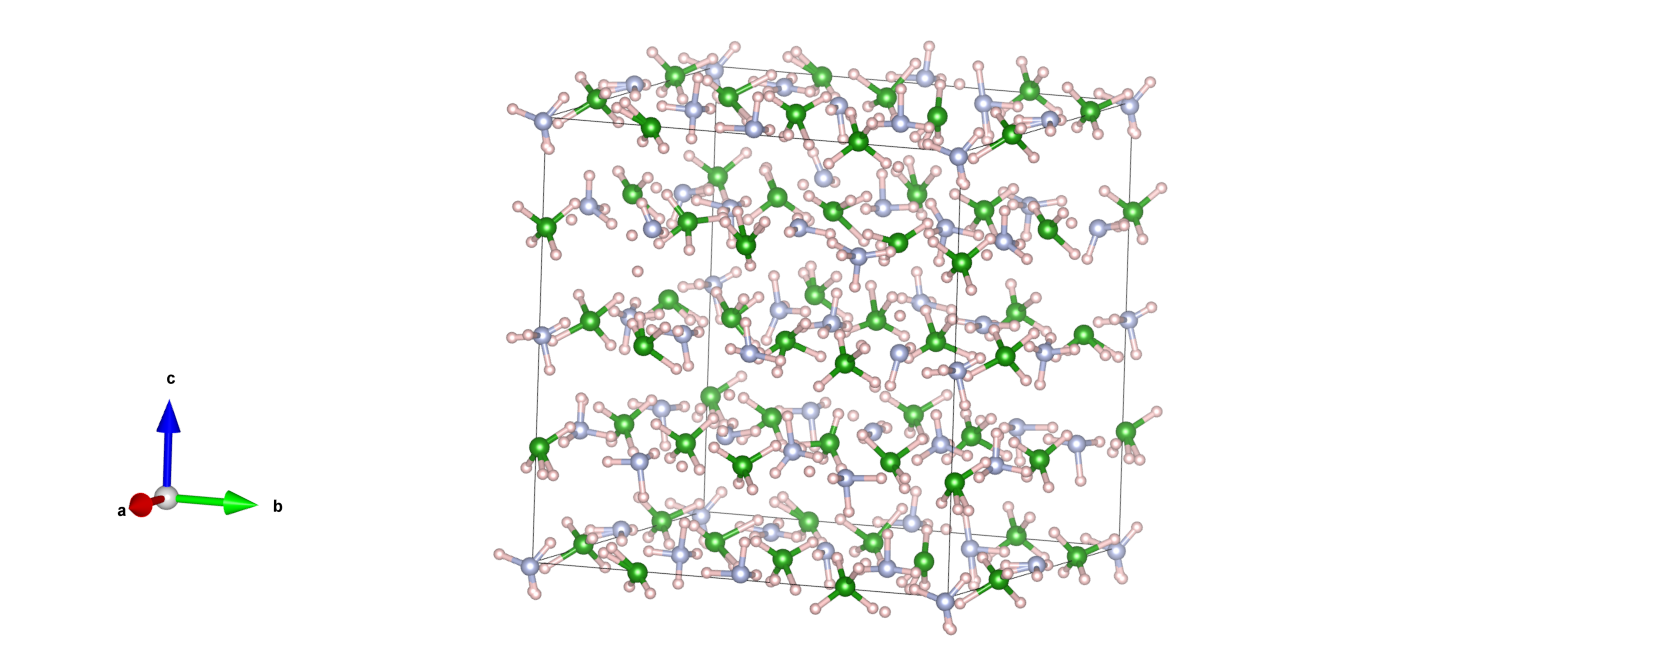

In [14]:
# let's put the B and N atoms together and visualise them (in VESTA)
Image("POSCAR_PSO_only.png")
# some of the complexes are not correctly reproduced. 
# also,the conter atoms (N and B) are located in planes, so let's 
# round their coordinates so be in those planes -- it will be easier
# for symmetry searching routines to identify symmetry

In [15]:
# here we segregate the imput array into planes. Since the PSO output 
# is rather scattered, I will set rather large tolerance
tol = 0.1
seg_N_PSO = round_positions(posN_PSO,tolerance=0.1)
seg_B_PSO = round_positions(posB_PSO,tolerance=0.1)
# and now let's visualise only these 
only_NB_segregated = np.append(seg_N_PSO,seg_B_PSO,axis=0)
txt2POSCAR = mk_text_for_POSCAR(sys_name='NH4BH4: only N and B',
                                at_lst_names=['N','B'],
                                sc_factor = 1.0,
                                SC_atoms = np.array([seg_N_PSO.shape[0],
                                                    seg_B_PSO.shape[0]])
                           )
cwd = os.getcwd()
write_POSCAR(fname=cwd + '/POSCAR_PSO_only_seg_N-B',pos_step=only_NB_segregated,
             lat_data=outcar.lattice[:,:,0],
             text_to_POSCAR=txt2POSCAR,
             flag_direct=True)

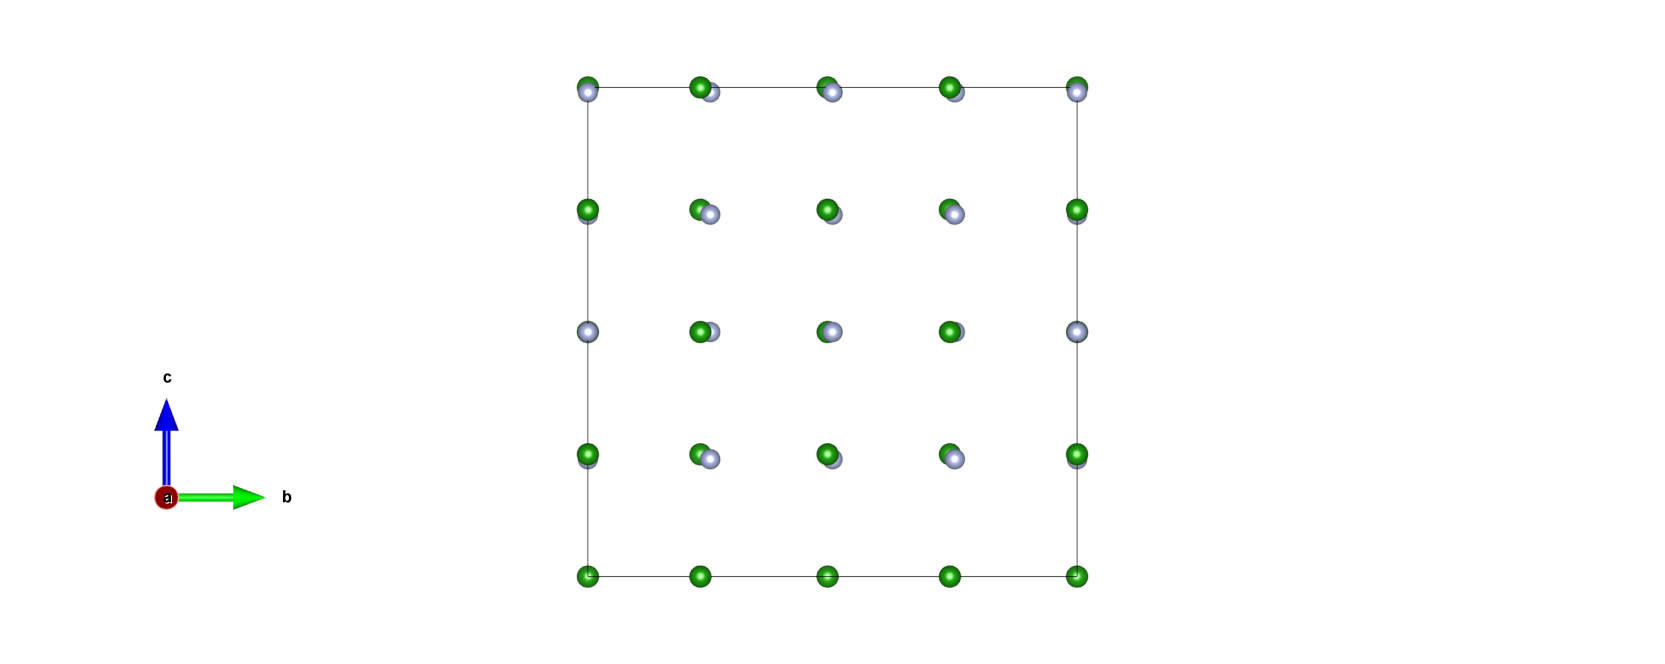

In [16]:
# the result is not fascinating: the symmetry is still P1
# but the structure looks better
Image("POSCAR_PSO_only_NB_seg.png")

In [17]:
seg_B_PSO

array([[0.25, 0.99, 1.  ],
       [0.76, 0.99, 1.  ],
       [0.25, 0.49, 1.  ],
       [0.76, 0.49, 1.  ],
       [0.25, 0.99, 0.5 ],
       [0.76, 0.99, 0.5 ],
       [0.25, 0.49, 0.5 ],
       [0.76, 0.49, 0.5 ],
       [1.  , 0.23, 1.  ],
       [0.5 , 0.23, 1.  ],
       [1.  , 0.74, 1.  ],
       [0.5 , 0.74, 1.  ],
       [1.  , 0.23, 0.5 ],
       [0.5 , 0.23, 0.5 ],
       [1.  , 0.74, 0.5 ],
       [0.5 , 0.74, 0.5 ],
       [1.  , 0.99, 0.25],
       [0.5 , 0.99, 0.25],
       [1.  , 0.49, 0.25],
       [0.5 , 0.49, 0.25],
       [1.  , 0.99, 0.75],
       [0.5 , 0.99, 0.75],
       [1.  , 0.49, 0.75],
       [0.5 , 0.49, 0.75],
       [0.25, 0.23, 0.25],
       [0.76, 0.23, 0.25],
       [0.25, 0.74, 0.25],
       [0.76, 0.74, 0.25],
       [0.25, 0.23, 0.75],
       [0.76, 0.23, 0.75],
       [0.25, 0.74, 0.75],
       [0.76, 0.74, 0.75]])

In [19]:
# presence of 0.25, 0.5, 0.75, and 1.0 suggest that those 
# are the symmetyrically correct positions. Thus we should
# replace values 0.23, 0.59, 0.51, 0.74, 0.76, 1.01 to the corresponding above
what2search = np.array([0.23, 0.49, 0.51, 0.74, 0.76, 1.01])
replace = np.array([0.25, 0.5, 0.5, 0.75, 0.75, 1.00])
set_vals_in_array(seg_B_PSO,what2search,replace)

array([[0.25, 0.99, 1.  ],
       [0.75, 0.99, 1.  ],
       [0.25, 0.5 , 1.  ],
       [0.75, 0.5 , 1.  ],
       [0.25, 0.99, 0.5 ],
       [0.75, 0.99, 0.5 ],
       [0.25, 0.5 , 0.5 ],
       [0.75, 0.5 , 0.5 ],
       [1.  , 0.25, 1.  ],
       [0.5 , 0.25, 1.  ],
       [1.  , 0.75, 1.  ],
       [0.5 , 0.75, 1.  ],
       [1.  , 0.25, 0.5 ],
       [0.5 , 0.25, 0.5 ],
       [1.  , 0.75, 0.5 ],
       [0.5 , 0.75, 0.5 ],
       [1.  , 0.99, 0.25],
       [0.5 , 0.99, 0.25],
       [1.  , 0.5 , 0.25],
       [0.5 , 0.5 , 0.25],
       [1.  , 0.99, 0.75],
       [0.5 , 0.99, 0.75],
       [1.  , 0.5 , 0.75],
       [0.5 , 0.5 , 0.75],
       [0.25, 0.25, 0.25],
       [0.75, 0.25, 0.25],
       [0.25, 0.75, 0.25],
       [0.75, 0.75, 0.25],
       [0.25, 0.25, 0.75],
       [0.75, 0.25, 0.75],
       [0.25, 0.75, 0.75],
       [0.75, 0.75, 0.75]])

In [20]:
seg_N_PSO
# The situation here is similar with the one above and solves in the same way
# After the coordinates are corrected in this way (It is where the researcher makes the decision)
# we should populate space around each N and B with H forming complexes.
# This is done below where the N and B positions are obtained as average

array([[-0.01, -0.  , -0.01],
       [ 0.5 , -0.  , -0.01],
       [-0.01,  0.5 , -0.01],
       [ 0.5 ,  0.5 , -0.01],
       [-0.01, -0.  ,  0.5 ],
       [ 0.5 , -0.  ,  0.5 ],
       [-0.01,  0.5 ,  0.5 ],
       [ 0.5 ,  0.5 ,  0.5 ],
       [ 0.24,  0.25, -0.01],
       [ 0.75,  0.25, -0.01],
       [ 0.24,  0.75, -0.01],
       [ 0.75,  0.75, -0.01],
       [ 0.24,  0.25,  0.5 ],
       [ 0.75,  0.25,  0.5 ],
       [ 0.24,  0.75,  0.5 ],
       [ 0.75,  0.75,  0.5 ],
       [ 0.24, -0.  ,  0.24],
       [ 0.75, -0.  ,  0.24],
       [ 0.24,  0.5 ,  0.24],
       [ 0.75,  0.5 ,  0.24],
       [ 0.24, -0.  ,  0.74],
       [ 0.75, -0.  ,  0.74],
       [ 0.24,  0.5 ,  0.74],
       [ 0.75,  0.5 ,  0.74],
       [-0.01,  0.25,  0.24],
       [ 0.5 ,  0.25,  0.24],
       [-0.01,  0.75,  0.24],
       [ 0.5 ,  0.75,  0.24],
       [-0.01,  0.25,  0.74],
       [ 0.5 ,  0.25,  0.74],
       [-0.01,  0.75,  0.74],
       [ 0.5 ,  0.75,  0.74]])

In [ ]:
# probably it is time to perfrom more "physical" symmetrization
# 1. average the N and B positions
# 2. segregate them into planes
# 3. add to each N and B H atoms. The bond lenghts and theis direction 
# will be result of averaging
# Surely due to direction randomness of the H bonds, the resulting 
# strucutre will be of triclinnic symmety, beu the N-B sublattice
# will have it

In [21]:
# dict of neighbours for N and H:
min_NH = 0.1
max_NH = 1.7
ligand_num = 4
NH_dr_dict = complexes_extract(pos_N_3d_all_steps,pos_H_3d_all_steps, 
                               outcar.lattice,ligand_num, 
                               min_NH,max_NH, False)
BH_dr_dict = complexes_extract(pos_B_3d_all_steps,pos_H_3d_all_steps, 
                               outcar.lattice,ligand_num, 
                               min_NH,max_NH, False)

In [22]:
# Average the N and B positions. We should not skip much of the data 
# since the averaging will be sensless then
fraction = 0.5 # of steps to skip
tol=1e-1 # the tolerance of setting the atoms in the planes
#
num_steps_total = pos_N_3d_all_steps.shape[0]
steps_skip = int(num_steps_total*fraction)
# perfrom averaging
pos_N_aver_f = np.average(pos_N_3d_all_steps[steps_skip:,:,:],axis=0).T
pos_B_aver_f = np.average(pos_B_3d_all_steps[steps_skip:,:,:],axis=0).T
# round positions of N and B:
rounded_N = round_positions(pos_N_aver_f,tolerance=tol)
rounded_B = round_positions(pos_B_aver_f,tolerance=tol)

In [23]:
rounded_B
# presence of 0.25, 0.5, 0.75, and 1.0 suggest that those 
# are the symmetyrically correct positions. Thus we should
# replace values 0.26, 0.51, 0.76, 1.01 to the corresponding

array([[0.25, 1.01, 1.01],
       [0.76, 1.01, 1.01],
       [0.25, 0.51, 1.01],
       [0.76, 0.51, 1.01],
       [0.25, 1.01, 0.5 ],
       [0.76, 1.01, 0.5 ],
       [0.25, 0.51, 0.5 ],
       [0.76, 0.51, 0.5 ],
       [1.  , 0.25, 1.01],
       [0.5 , 0.25, 1.01],
       [1.  , 0.76, 1.01],
       [0.5 , 0.76, 1.01],
       [1.  , 0.25, 0.5 ],
       [0.5 , 0.25, 0.5 ],
       [1.  , 0.76, 0.5 ],
       [0.5 , 0.76, 0.5 ],
       [1.  , 1.01, 0.26],
       [0.5 , 1.01, 0.26],
       [1.  , 0.51, 0.26],
       [0.5 , 0.51, 0.26],
       [1.  , 1.01, 0.75],
       [0.5 , 1.01, 0.75],
       [1.  , 0.51, 0.75],
       [0.5 , 0.51, 0.75],
       [0.25, 0.25, 0.26],
       [0.76, 0.25, 0.26],
       [0.25, 0.76, 0.26],
       [0.76, 0.76, 0.26],
       [0.25, 0.25, 0.75],
       [0.76, 0.25, 0.75],
       [0.25, 0.76, 0.75],
       [0.76, 0.76, 0.75]])

In [24]:
what2search = np.array([0.26, 0.51, 0.76, 1.01])
replace = np.array([0.25, 0.5, 0.75,1.0])
corr_rounded_B = set_vals_in_array(rounded_B,what2search,replace)
corr_rounded_B

array([[0.25, 1.  , 1.  ],
       [0.75, 1.  , 1.  ],
       [0.25, 0.5 , 1.  ],
       [0.75, 0.5 , 1.  ],
       [0.25, 1.  , 0.5 ],
       [0.75, 1.  , 0.5 ],
       [0.25, 0.5 , 0.5 ],
       [0.75, 0.5 , 0.5 ],
       [1.  , 0.25, 1.  ],
       [0.5 , 0.25, 1.  ],
       [1.  , 0.75, 1.  ],
       [0.5 , 0.75, 1.  ],
       [1.  , 0.25, 0.5 ],
       [0.5 , 0.25, 0.5 ],
       [1.  , 0.75, 0.5 ],
       [0.5 , 0.75, 0.5 ],
       [1.  , 1.  , 0.25],
       [0.5 , 1.  , 0.25],
       [1.  , 0.5 , 0.25],
       [0.5 , 0.5 , 0.25],
       [1.  , 1.  , 0.75],
       [0.5 , 1.  , 0.75],
       [1.  , 0.5 , 0.75],
       [0.5 , 0.5 , 0.75],
       [0.25, 0.25, 0.25],
       [0.75, 0.25, 0.25],
       [0.25, 0.75, 0.25],
       [0.75, 0.75, 0.25],
       [0.25, 0.25, 0.75],
       [0.75, 0.25, 0.75],
       [0.25, 0.75, 0.75],
       [0.75, 0.75, 0.75]])

In [25]:
# for sake of bugless adaptaions of the code following, I will 
# make rounded_B = corr_rounded_B
rounded_B = corr_rounded_B
#convert then to cartesian coordinates:
rounded_B_cart = frac2cart(rounded_B, outcar.lattice[:,:,0])
rounded_N_cart = frac2cart(rounded_N, outcar.lattice[:,:,0])

In [26]:
# write for a single value of skipped steps
fraction = 0.99

#
num_steps_total = pos_N_3d_all_steps.shape[0]
steps_skip = int(num_steps_total*fraction)
# set the output
pos_H_divine = np.zeros((pos_H.shape[2],3))
# add the H octahedra around:
# NH4 complexes
displacement=0
dr_dict = copy.deepcopy(NH_dr_dict)
for AtomNum in range(rounded_N_cart.shape[0]):
    dr =  dr_dict[AtomNum][steps_skip:,:,:]
    dr_norm_aver = np.average(np.linalg.norm(dr,axis=2),axis=0) # average bond length
    dr_average = np.average(dr,axis=0) # averaged direction of each bond
    # now it's time to scale the average direction by the average bond length
    dr_average_norm = np.linalg.norm(np.average(dr,axis=0),axis=1) # norm of the averaged direction vectors
    dr_average_unity = (dr_average.T/dr_average_norm).T # unity vectors in the direction f the averaged bond vectors
    dr_average_scaled = (dr_average_unity.T*dr_norm_aver).T # properly scaled; this is what you need
    for ligand in range(dr_average_scaled.shape[0]):
        pos_H_divine[displacement + AtomNum*ligand_num+ligand,:] = dr_average_scaled[ligand,:] + rounded_N_cart[AtomNum]
# BH4 complexes
dr_dict = copy.deepcopy(BH_dr_dict)
displacement = rounded_N_cart.shape[0]*ligand_num
for AtomNum in range(rounded_B_cart.shape[0]):
    dr =  dr_dict[AtomNum][steps_skip:,:,:]
    dr_norm_aver = np.average(np.linalg.norm(dr,axis=2),axis=0) # average bond length
    dr_average = np.average(dr,axis=0) # averaged direction of each bond
    # now it's time to scale the average direction by the average bond length
    dr_average_norm = np.linalg.norm(np.average(dr,axis=0),axis=1) # norm of the averaged direction vectors
    dr_average_unity = (dr_average.T/dr_average_norm).T # unity vectors in the direction f the averaged bond vectors
    dr_average_scaled = (dr_average_unity.T*dr_norm_aver).T # properly scaled; this is what you need
    for ligand in range(dr_average_scaled.shape[0]):
        pos_H_divine[displacement + AtomNum*ligand_num+ligand,:] = dr_average_scaled[ligand,:] + rounded_B_cart[AtomNum]
        
# save the output
positions_divine_NB = np.append(rounded_N_cart, rounded_B_cart , axis=0)
positions_divine = np.append(positions_divine_NB,pos_H_divine,axis=0)
positions_divine_frac = cart2frac(positions_divine,outcar.lattice[:,:,0])
system_name='symm_divine'
fname = system_name + '_POSCAR_skipped_' + str(fraction*100)+'_percent.vasp'
txt2POSCAR = mk_text_for_POSCAR(system_name,outcar.name_atoms,1.0,outcar.NumAtoms)
write_POSCAR(fname ,positions_divine_frac,outcar.lattice[:,:,0],txt2POSCAR,True)

# Multiprocessing

In [ ]:
# searching for the bonds is a time consuming task on a single core.
# here is a simple parallelization 

In [27]:
# this ficntion will combine the parallelized output into the 
# one used here
def extract_data_to_bond_dict(_jb_res_):
    _result_ = {}
    for idx in range(len(_jb_res_.keys())):
        for idx_center in range(len(_jb_res_[idx].keys())):
            if idx == 0:
                _result_[idx_center] = _jb_res_[idx][idx_center]
            else:
                _result_[idx_center] = np.append(_result_[idx_center],_jb_res_[idx][idx_center], axis=0)
    return _result_

In [28]:
ARGS = ((pos_N_3d_all_steps,pos_H_3d_all_steps,outcar.lattice),(ligand_num,min_NH,max_NH),)
double_transpose = [False,False,True]
paral_NH = parallelize_framework(function=complexes_extract,_ARGS_=ARGS,double_transpose_fix=double_transpose)
ARGS = ((pos_B_3d_all_steps,pos_H_3d_all_steps,outcar.lattice),(ligand_num,min_NH,max_NH),)
paral_BH = parallelize_framework(function=complexes_extract,_ARGS_=ARGS,double_transpose_fix=double_transpose)

In [29]:
# convert:
complexes_NH = extract_data_to_bond_dict(paral_NH)
complexes_BH = extract_data_to_bond_dict(paral_BH)

In [30]:
# check correctness:
for key in complexes_NH.keys():
    print(key, np.min(complexes_NH[key] - NH_dr_dict[key]))

(0, 0.0)
(1, 0.0)
(2, 0.0)
(3, 0.0)
(4, 0.0)
(5, 0.0)
(6, 0.0)
(7, 0.0)
(8, 0.0)
(9, 0.0)
(10, 0.0)
(11, 0.0)
(12, 0.0)
(13, 0.0)
(14, 0.0)
(15, 0.0)
(16, 0.0)
(17, 0.0)
(18, 0.0)
(19, 0.0)
(20, 0.0)
(21, 0.0)
(22, 0.0)
(23, 0.0)
(24, 0.0)
(25, 0.0)
(26, 0.0)
(27, 0.0)
(28, 0.0)
(29, 0.0)
(30, 0.0)
(31, 0.0)


In [31]:
# check correctness:
for key in complexes_BH.keys():
    print(key, np.min(complexes_BH[key] - BH_dr_dict[key]))

(0, 0.0)
(1, 0.0)
(2, 0.0)
(3, 0.0)
(4, 0.0)
(5, 0.0)
(6, 0.0)
(7, 0.0)
(8, 0.0)
(9, 0.0)
(10, 0.0)
(11, 0.0)
(12, 0.0)
(13, 0.0)
(14, 0.0)
(15, 0.0)
(16, 0.0)
(17, 0.0)
(18, 0.0)
(19, 0.0)
(20, 0.0)
(21, 0.0)
(22, 0.0)
(23, 0.0)
(24, 0.0)
(25, 0.0)
(26, 0.0)
(27, 0.0)
(28, 0.0)
(29, 0.0)
(30, 0.0)
(31, 0.0)
